In [226]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

train["CONDITION"] = train.CONDITION.map({"H":0, "D":1})
test["CONDITION"] = test.CONDITION.map({"H":0, "D":1})

X_train = train.iloc[:,1:13]
y_train = train['CONDITION']
print(X_train.columns)
X_test= test.iloc[:,1:13]
y_test = test['CONDITION']

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)

scaler = MinMaxScaler().fit(X_test)
X_test = scaler.transform(X_test)

X_full = np.vstack((X_train, X_test))
y_full = np.concatenate((list(y_train), list(y_test)))
print(X_full[0])
print(y_full.shape)

Index(['P1', 'N2', 'P3', 'M4', 'P5', 'M6', 'N7', 'N8', 'M9', 'P10', 'M11',
       'N12'],
      dtype='object')
[1.   0.25 0.   0.25 0.   0.   0.5  0.5  0.   0.5  0.   0.  ]
(968,)


In [227]:
# ALL metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [236]:
df_results = pd.DataFrame(columns = ['model', 'accuracy', 'variance', 'precision', 'recall', 'roc_auc'])
kfold = model_selection.KFold(n_splits=10)
modelCV = LogisticRegression(max_iter=10000)
scoring = {'acc': 'accuracy',
           'var' : 'explained_variance',
           'precision': 'precision',
           'recall': 'recall',
           'roc_auc': 'roc_auc'}

results = model_selection.cross_validate(modelCV, X_full, y_full, cv=kfold, scoring=scoring)
new_row = pd.Series(['Logistic Regression 12 variables', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()], index = df_results.columns)
                     
df_results.append(new_row, ignore_index=True)

,model,accuracy,variance,precision,recall,roc_auc
0,Logistic Regression 12 variables,0.760384,0.039734,0.752728,0.77012,0.851367


In [237]:
for i in range(1,13):
    X_new = SelectKBest(chi2, k=i).fit_transform(X_full, y_full)

    kfold = model_selection.KFold(n_splits=10)
    modelCV = LogisticRegression(max_iter=1000)
    
    results = model_selection.cross_validate(modelCV, X_new, y_full, cv=kfold, scoring=scoring)
    df_results.loc[len(df_results)] = ['Logistic Regression ' + str(i) + ' variables', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

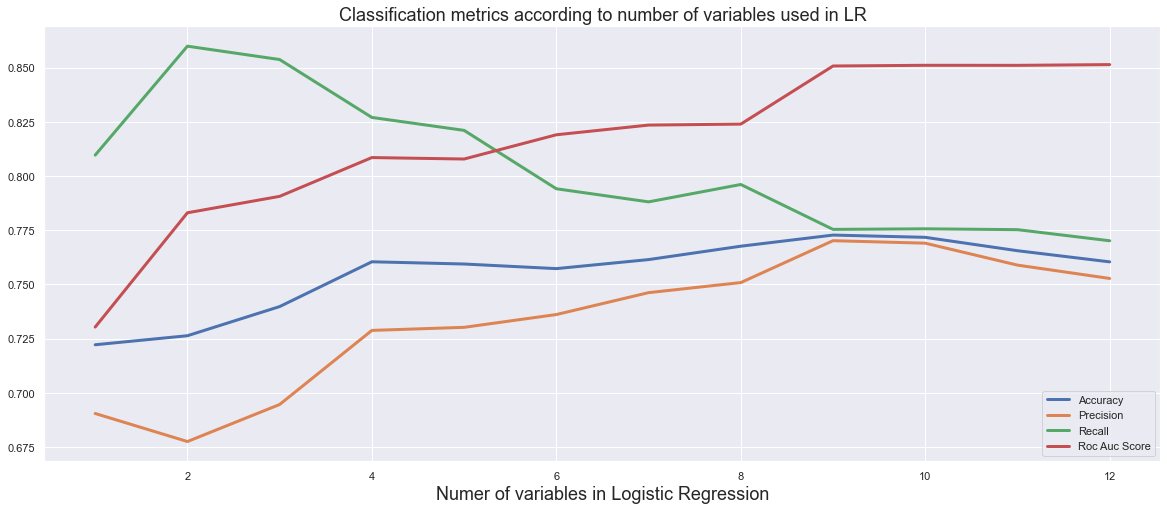

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'darkgrid')
plt.rcParams["figure.figsize"] = (20,8)

plt.plot(range(1,13), df_results['accuracy'], lw=3, label = 'Accuracy')
#plt.plot(range(1,13), df_results['variance'], lw=3, label = 'Variance')
plt.plot(range(1,13), df_results['precision'], lw=3, label = 'Precision')
plt.plot(range(1,13), df_results['recall'], lw=3, label = 'Recall')
plt.plot(range(1,13), df_results['roc_auc'], lw=3, label = 'Roc Auc Score')
plt.xlabel("Numer of variables in Logistic Regression", size=18)
plt.title('Classification metrics according to number of variables used in LR', size=18)
plt.legend()
plt.savefig('LR-number-of-vars', bbox_inches='tight')

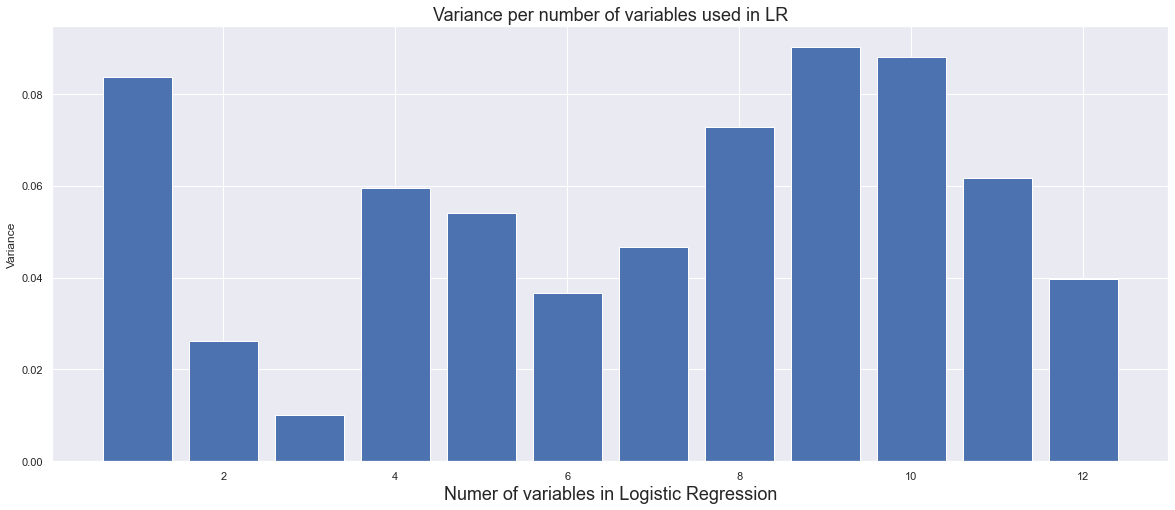

In [239]:
plt.bar(range(1,13), height=abs(df_results['variance']))
plt.title('Variance per number of variables used in LR', size=18)
plt.xlabel('Numer of variables in Logistic Regression', size=18)
plt.ylabel('Variance')
plt.savefig('LR-variance', bbox_inches='tight')

### Remove Machiavelism features because they are correlated

In [247]:
print(X_full.shape)
X_removed = np.delete(X_full, [3, 5, 8, 10], 1)
print(X_removed.shape)

modelCV = LogisticRegression(max_iter=1000)
results = model_selection.cross_validate(modelCV, X_removed, y_full, cv=kfold, scoring=scoring)
print(['Logistic Regression without M features:', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()])

(968, 12)
(968, 8)
['Logistic Regression without M features:', 0.751063144329897, 0.0020469769217390742, 0.7523705306373385, 0.7460986747504724, 0.8399777390246387]


In [248]:
selected_results = pd.DataFrame(columns = ['model', 'accuracy', 'variance', 'precision', 'recall', 'roc_auc'])
selected_results.loc[len(selected_results)] = ['Logistic Regression', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [242]:
clf = GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']}, cv=5).fit(X_removed, y_full)

print(clf.best_params_)

{'C': 1, 'kernel': 'rbf'}


In [249]:
modelCV = SVC(C=1, kernel='rbf')
results = model_selection.cross_validate(modelCV, X_removed, y_full, cv=kfold, scoring=scoring)
selected_results.loc[len(selected_results)] = ['SVM (rbf)', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [250]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
results = model_selection.cross_validate(clf, X_removed, y_full, cv=kfold, scoring=scoring)
selected_results.loc[len(selected_results)] = ['Random forest', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [251]:
clf = GaussianNB()
results = model_selection.cross_validate(clf, X_removed, y_full, cv=kfold, scoring=scoring)
selected_results.loc[len(selected_results)] = ['Naive Bayes', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [252]:
hl_parameters = {'hidden_layer_sizes': [(10,), (50,),(100,), (10,10,)]}

mlp_cv = MLPClassifier(max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1,random_state=0) 
clf = GridSearchCV(estimator=mlp_cv, param_grid=hl_parameters,cv=5).fit(X_removed, y_full)
print(clf.best_params_['hidden_layer_sizes'])

mlp = MLPClassifier(hidden_layer_sizes = clf.best_params_['hidden_layer_sizes'], verbose=0, max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=0)
results = model_selection.cross_validate(mlp, X_removed, y_full, cv=kfold, scoring=scoring)
selected_results.loc[len(selected_results)] = ['MLP (50)', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

(50,)


In [253]:
xgb = XGBClassifier(verbosity = 0)
results = model_selection.cross_validate(xgb, X_removed, y_full, cv=kfold, scoring=scoring)
selected_results.loc[len(selected_results)] = ['XGB', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

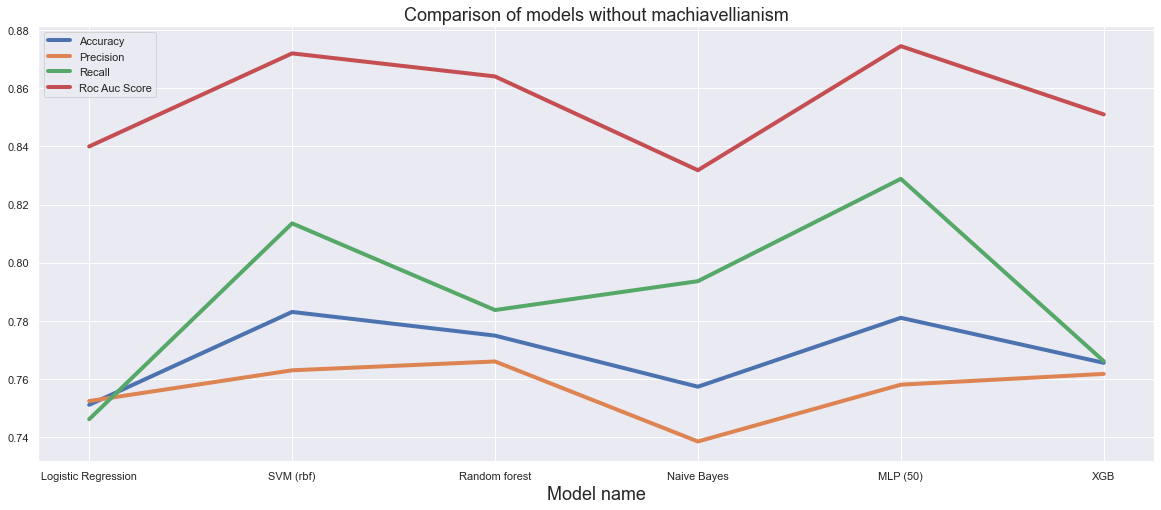

In [254]:
plt.plot(range(len(selected_results)), selected_results['accuracy'], lw=4, label = 'Accuracy')
plt.plot(range(len(selected_results)), selected_results['precision'], lw=4, label = 'Precision')
plt.plot(range(len(selected_results)), selected_results['recall'], lw=4, label = 'Recall')
plt.plot(range(len(selected_results)), selected_results['roc_auc'], lw=4, label = 'Roc Auc Score')
plt.xticks(range(len(selected_results)), selected_results['model'])
plt.legend()
plt.title('Comparison of models without machiavellianism', size=18)
plt.xlabel('Model name', size=18)
plt.savefig('classification-8-features-comparison', bbox_inches='tight')

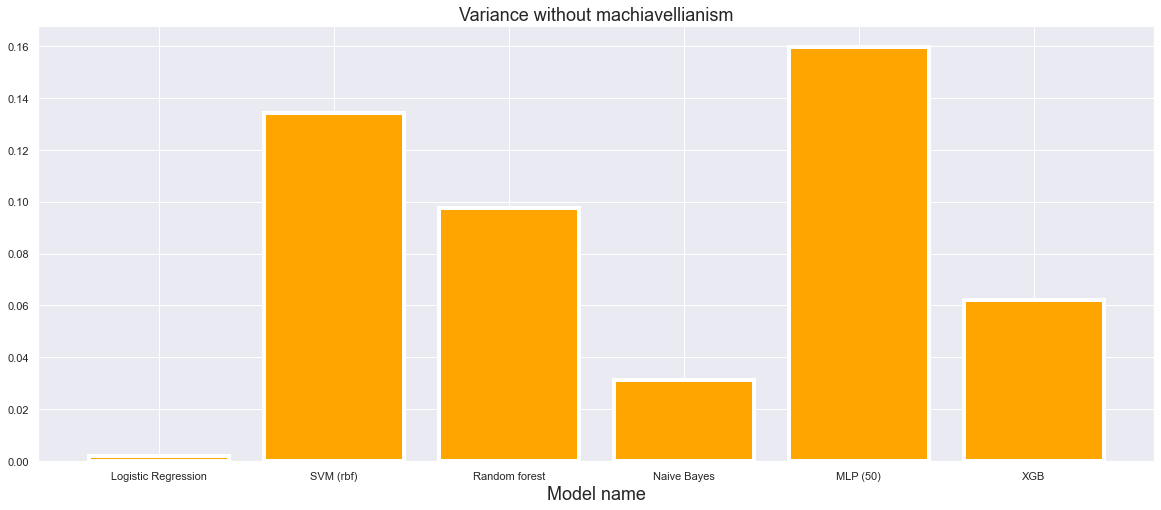

In [255]:
plt.bar(range(len(selected_results)), selected_results['variance'], lw=4, label = 'Accuracy', color='orange')
plt.xticks(range(len(selected_results)), selected_results['model'])
plt.title('Variance without machiavellianism', size=18)
plt.xlabel('Model name', size=18)
plt.savefig('classification-8-features-variance', bbox_inches='tight')

## Full models comparison

Benchmark accuracy: 0.78 (after removing outliers 0.75)

In [256]:
best_scores = pd.DataFrame(columns = ['model', 'accuracy', 'variance', 'precision', 'recall', 'roc_auc'])
X_new = SelectKBest(chi2, k=9).fit_transform(X_full, y_full)
kfold = model_selection.KFold(n_splits=10)
modelCV = LogisticRegression(max_iter=1000)

results = model_selection.cross_validate(modelCV, X_new, y_full, cv=kfold, scoring=scoring)
best_scores.loc[len(best_scores)] = ['LR', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [257]:
modelCV = SVC(C=1, kernel='poly')

results = model_selection.cross_validate(modelCV, X_full, y_full, cv=kfold, scoring=scoring)
best_scores.loc[len(best_scores)] = ['SVM (poly)', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [258]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
results = model_selection.cross_validate(clf, X_full, y_full, cv=kfold, scoring=scoring)
best_scores.loc[len(best_scores)] = ['Random forest', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [259]:
clf = GaussianNB()
results = model_selection.cross_validate(clf, X_full, y_full, cv=kfold, scoring=scoring)
best_scores.loc[len(best_scores)] = ['Naive Bayes', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [260]:
hl_parameters = {'hidden_layer_sizes': [(10,), (50,),(100,), (10,10,)]}

mlp_cv = MLPClassifier(max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1,random_state=0) 
clf = GridSearchCV(estimator=mlp_cv, param_grid=hl_parameters,cv=5).fit(X_removed, y_full)
print(clf.best_params_['hidden_layer_sizes'])

(50,)


In [261]:
mlp = MLPClassifier(hidden_layer_sizes = clf.best_params_['hidden_layer_sizes'], verbose=0, max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=0)
results = model_selection.cross_validate(mlp, X_full, y_full, cv=kfold, scoring=scoring)
best_scores.loc[len(best_scores)] = ['MLP (50, )', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [262]:
xgb = XGBClassifier(verbosity=0)
results = model_selection.cross_validate(xgb, X_full, y_full, cv=kfold, scoring=scoring)
best_scores.loc[len(best_scores)] = ['XGB', 
                 results['test_acc'].mean(), 
                 results['test_var'].mean(), 
                 results['test_precision'].mean(),
                 results['test_recall'].mean(),
                 results['test_roc_auc'].mean()]

In [263]:
best_scores

,model,accuracy,variance,precision,recall,roc_auc
0,LR,0.772745,0.090151,0.770156,0.775366,0.850724
1,SVM (poly),0.788198,0.180852,0.745548,0.872670,0.867244
2,Random forest,0.803737,0.212506,0.798889,0.806844,0.878234
3,Naive Bayes,0.745973,0.016138,0.707142,0.836573,0.831591
4,"MLP (50, )",0.797530,0.193710,0.815769,0.760944,0.886865
5,XGB,0.790367,0.156619,0.789614,0.787878,0.872924


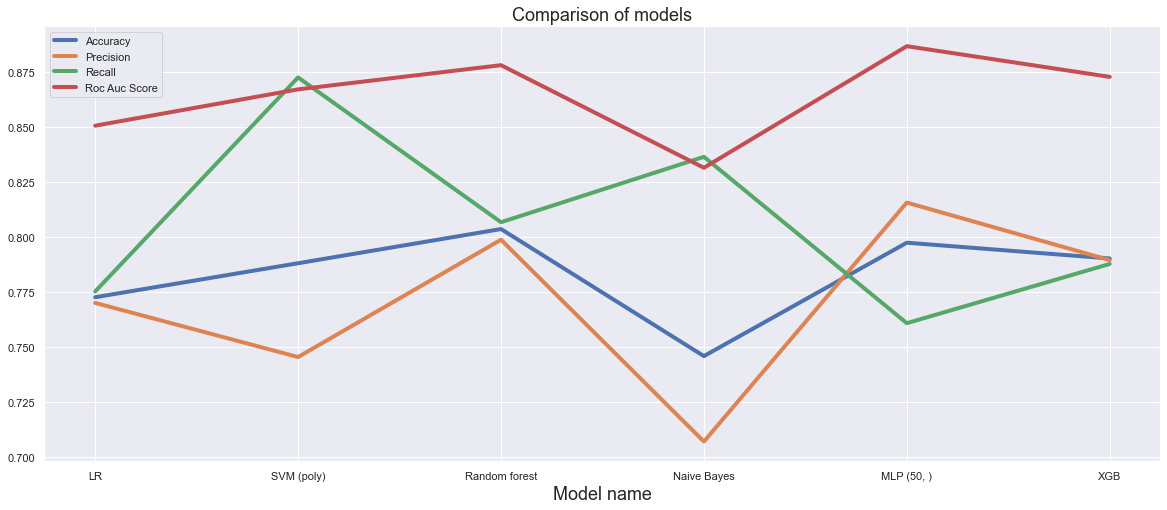

In [264]:
plt.plot(range(len(best_scores)), best_scores['accuracy'], lw=4, label = 'Accuracy')
plt.plot(range(len(best_scores)), best_scores['precision'], lw=4, label = 'Precision')
plt.plot(range(len(best_scores)), best_scores['recall'], lw=4, label = 'Recall')
plt.plot(range(len(best_scores)), best_scores['roc_auc'], lw=4, label = 'Roc Auc Score')
plt.xticks(range(len(best_scores)), best_scores['model'])
plt.legend()
plt.title('Comparison of models', size=18)
plt.xlabel('Model name', size=18)
plt.savefig('classification-models-comparison', bbox_inches='tight')

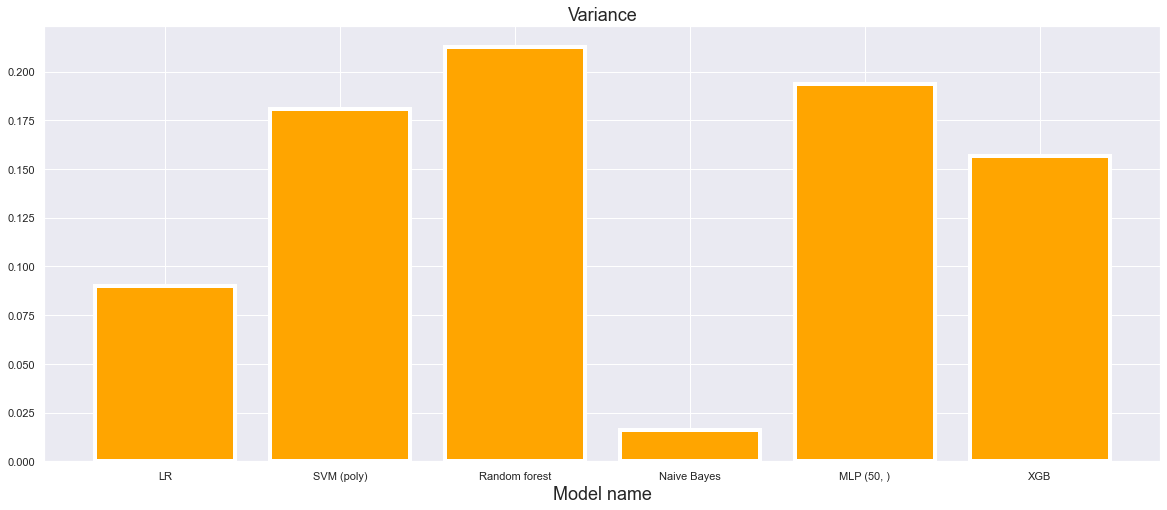

In [265]:
plt.bar(range(len(best_scores)), best_scores['variance'], lw=4, label = 'Accuracy', color='orange')
plt.xticks(range(len(best_scores)), best_scores['model'])
plt.title('Variance', size=18)
plt.xlabel('Model name', size=18)
plt.savefig('classification-variance', bbox_inches='tight')

## Best model: Random forest (highest accuracy and interptetable) 
the variance is the highest too, but the difference beween variance among the models is small

In [266]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: " + str(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.8402061855670103


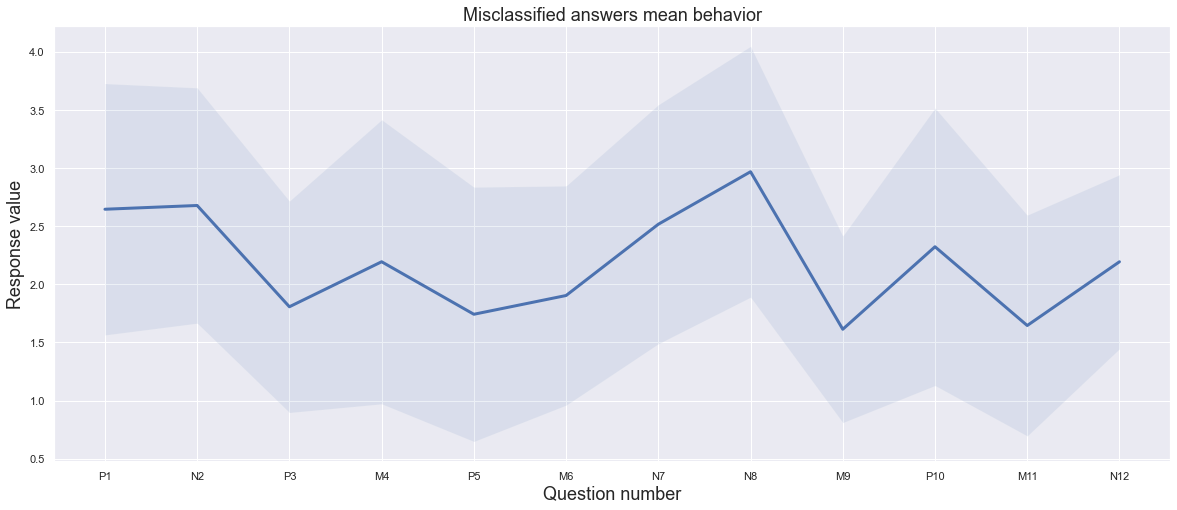

In [267]:
# Misclassified samples:
missclassified = test[(y_pred != y_test)].iloc[:,1:13]
plt.plot(missclassified.mean(axis=0), lw=3, label='mean')
plt.fill_between(range(12),missclassified.mean(axis=0)-missclassified.std(axis=0),
                         missclassified.mean(axis=0)+missclassified.std(axis=0), alpha=.1)
plt.xlabel('Question number',size=18)
plt.ylabel('Response value', size=18)
plt.title('Misclassified answers mean behavior',size=18)
plt.savefig('misclassified', bbox_inches='tight')

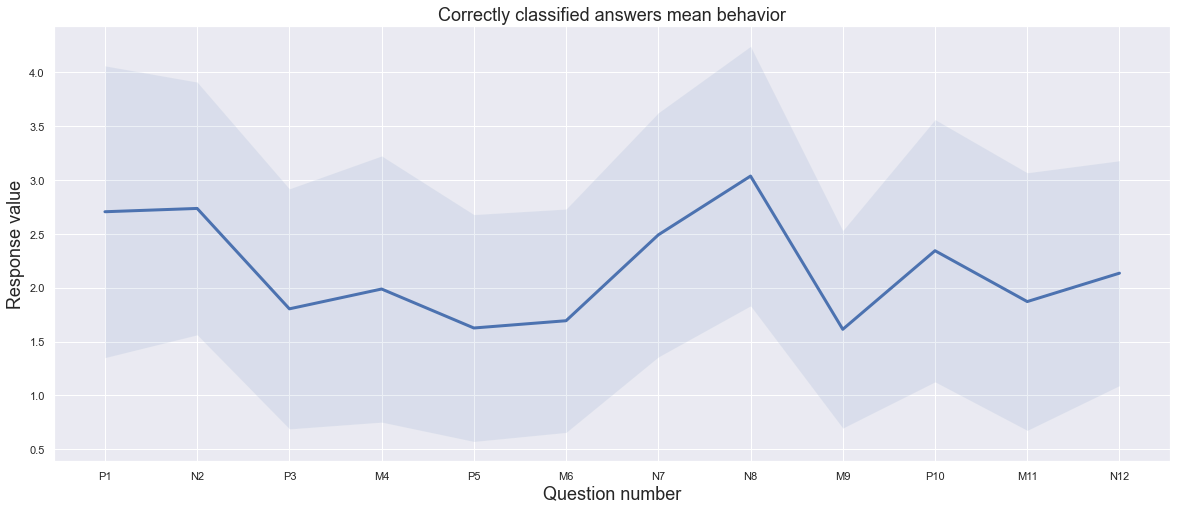

In [268]:
# Correctly classified samples:
correct = test[(y_pred == y_test)].iloc[:,1:13]
plt.plot(correct.mean(axis=0), lw=3, label='mean')
plt.fill_between(range(12),correct.mean(axis=0)-correct.std(axis=0),
                         correct.mean(axis=0)+correct.std(axis=0), alpha=.1)
plt.xlabel('Question number',size=18)
plt.ylabel('Response value', size=18)
plt.title('Correctly classified answers mean behavior',size=18)
plt.savefig('correctly-classified', bbox_inches='tight')

In [269]:
predicted_dishonest = test[(y_pred == 1)]
predicted_dishonest.to_csv('original_model_predicted_dishonest.csv', index=False)

## TF-IDF

benchmark accuracy: 0.91

In [270]:
train = pd.read_csv('tfidf_train_dataset.csv')
test = pd.read_csv('tfidf_test_dataset.csv')

train["CONDITION"] = train.CONDITION.map({"H":0, "D":1})
test["CONDITION"] = test.CONDITION.map({"H":0, "D":1})

X_train = train.iloc[:,0:12]
y_train = train['CONDITION']
X_test= test.iloc[:,0:12]
y_test = test['CONDITION']

tf_idf_scores = pd.DataFrame(columns = ['model', 'accuracy', 'precision', 'recall', 'variance',  'roc_auc'])

model_logreg = LogisticRegression()
model_logreg.fit(X_train, y_train)
y_pred = model_logreg.predict(X_test)

tf_idf_scores.loc[len(tf_idf_scores)] = ['Logistic Regression', 
                 metrics.accuracy_score(y_test, y_pred), 
                 metrics.precision_score(y_test, y_pred), 
                 metrics.recall_score(y_test, y_pred),
                 metrics.explained_variance_score(y_test, y_pred),
                 metrics.roc_auc_score(y_test, y_pred)]
tf_idf_scores

,model,accuracy,precision,recall,variance,roc_auc
0,Logistic Regression,0.908163,0.934783,0.877551,0.636401,0.908163


In [272]:
model_logreg =  SVC(C=1, kernel='poly')
model_logreg.fit(X_train, y_train)
y_pred = model_logreg.predict(X_test)

tf_idf_scores.loc[len(tf_idf_scores)] = ['SVM (poly)', 
                 metrics.accuracy_score(y_test, y_pred), 
                 metrics.precision_score(y_test, y_pred), 
                 metrics.recall_score(y_test, y_pred),
                 metrics.explained_variance_score(y_test, y_pred),
                 metrics.roc_auc_score(y_test, y_pred)]

tf_idf_scores

,model,accuracy,precision,recall,variance,roc_auc
0,Logistic Regression,0.908163,0.934783,0.877551,0.636401,0.908163
1,SVM (poly),0.959184,1.000000,0.918367,0.843399,0.959184


In [273]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

tf_idf_scores.loc[len(tf_idf_scores)] = ['Naive Bayes', 
                 metrics.accuracy_score(y_test, y_pred), 
                 metrics.precision_score(y_test, y_pred), 
                 metrics.recall_score(y_test, y_pred),
                 metrics.explained_variance_score(y_test, y_pred),
                 metrics.roc_auc_score(y_test, y_pred)]

tf_idf_scores

,model,accuracy,precision,recall,variance,roc_auc
0,Logistic Regression,0.908163,0.934783,0.877551,0.636401,0.908163
1,SVM (poly),0.959184,1.000000,0.918367,0.843399,0.959184
2,Naive Bayes,0.979592,0.979592,0.979592,0.918367,0.979592


In [274]:
mlp = MLPClassifier(hidden_layer_sizes = (50,), verbose=0, max_iter=300, alpha=1e-4, solver='sgd', tol=1e-4, learning_rate_init=.1, random_state=0)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

tf_idf_scores.loc[len(tf_idf_scores)] = ['MLP', 
                 metrics.accuracy_score(y_test, y_pred), 
                 metrics.precision_score(y_test, y_pred), 
                 metrics.recall_score(y_test, y_pred),
                 metrics.explained_variance_score(y_test, y_pred),
                 metrics.roc_auc_score(y_test, y_pred)]

tf_idf_scores

,model,accuracy,precision,recall,variance,roc_auc
0,Logistic Regression,0.908163,0.934783,0.877551,0.636401,0.908163
1,SVM (poly),0.959184,1.000000,0.918367,0.843399,0.959184
2,Naive Bayes,0.979592,0.979592,0.979592,0.918367,0.979592
3,MLP,0.979592,0.979592,0.979592,0.918367,0.979592


In [275]:
xgb = XGBClassifier() 
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

tf_idf_scores.loc[len(tf_idf_scores)] = ['XGB', 
                 metrics.accuracy_score(y_test, y_pred), 
                 metrics.precision_score(y_test, y_pred), 
                 metrics.recall_score(y_test, y_pred),
                 metrics.explained_variance_score(y_test, y_pred),
                 metrics.roc_auc_score(y_test, y_pred)]

tf_idf_scores

,model,accuracy,precision,recall,variance,roc_auc
0,Logistic Regression,0.908163,0.934783,0.877551,0.636401,0.908163
1,SVM (poly),0.959184,1.000000,0.918367,0.843399,0.959184
2,Naive Bayes,0.979592,0.979592,0.979592,0.918367,0.979592
3,MLP,0.979592,0.979592,0.979592,0.918367,0.979592
4,XGB,1.000000,1.000000,1.000000,1.000000,1.000000


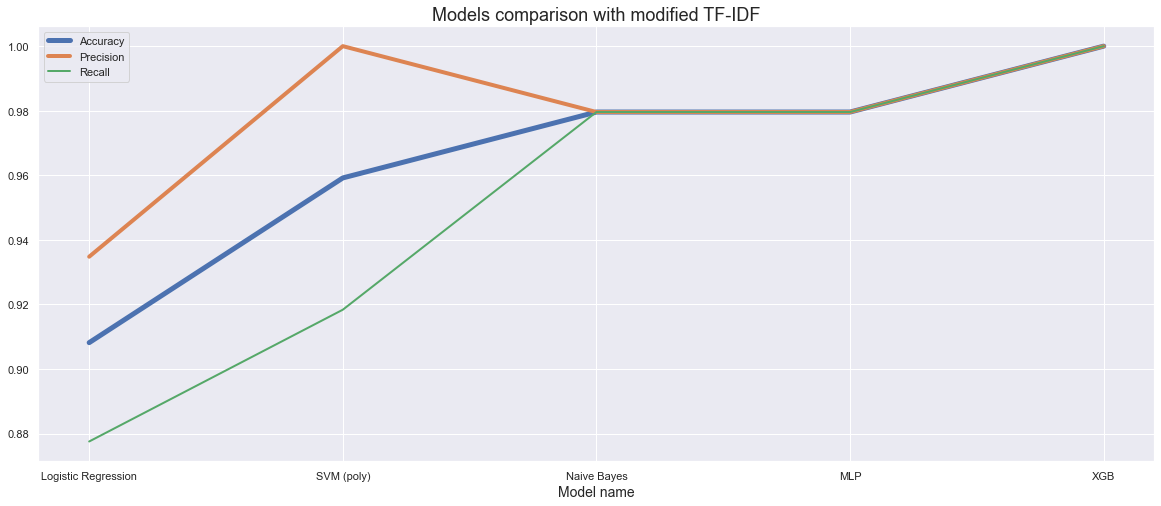

In [279]:
plt.plot(range(len(tf_idf_scores)), tf_idf_scores['accuracy'], lw=5, label = 'Accuracy')
#plt.plot(range(1,13), df_results['variance'], lw=3, label = 'Variance')
plt.plot(range(len(tf_idf_scores)), tf_idf_scores['precision'], lw=4, label = 'Precision')
plt.plot(range(len(tf_idf_scores)), tf_idf_scores['recall'], lw=2, label = 'Recall')
#plt.plot(range(len(tf_idf_scores)), tf_idf_scores['roc_auc'], lw=3, label = 'Roc Auc Score')
plt.xticks(range(len(tf_idf_scores)), tf_idf_scores['model'])
plt.legend()
plt.xlabel('Model name', size=14)
plt.title('Models comparison with modified TF-IDF', size=18)
plt.savefig('classification-comparison-tfidf', bbox_inches='tight')

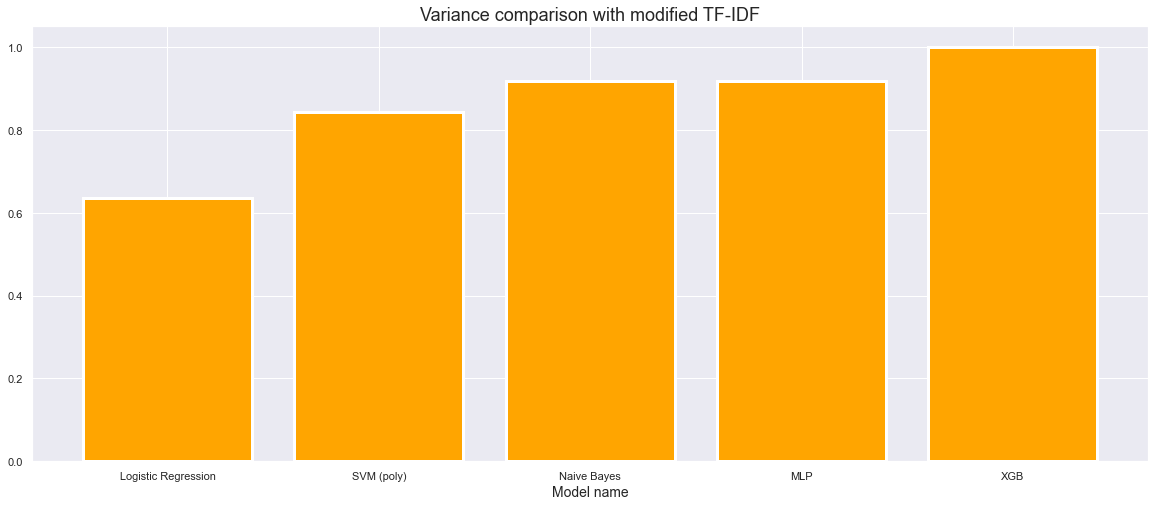

In [280]:
plt.bar(range(len(tf_idf_scores)), tf_idf_scores['variance'], lw=3, label = 'Variance', color='orange')
plt.xticks(range(len(tf_idf_scores)), tf_idf_scores['model'])
plt.xlabel('Model name', size=14)
plt.title('Variance comparison with modified TF-IDF', size=18)
plt.savefig('variance-comparison-tfidf', bbox_inches='tight')

# Benchmark classification accuracy

In [271]:
# Benchmark accuracy for classification:

avg_vector = X_train.mean(axis=0)

# Substract the average vector for each test row and calculate the sum of differences
difference_sum = (X_test - avg_vector).sum(axis=1)
print(difference_sum)

# If the sum is positive, classify the row as honest, otherwise classify as dishonest
classification = np.sign(difference_sum)

print("Prediction vector: ")
print(list(classification))

comparison_vector = y_test.replace(1, -1).replace(0, 1)
print(y_test)
print(comparison_vector)

# Count the number of equal classifications
print("\nAccuracy: ")
print(sum(classification == comparison_vector) / len(classification))

0     1.376592
1     1.352700
2     5.052987
3     3.368606
4     3.036957
        ...   
93   -3.219800
94   -5.560913
95   -5.777186
96   -4.828418
97   -4.968590
Length: 98, dtype: float64
Prediction vector: 
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
0     0
1     0
2     0
3     0
4     0
     ..
93    1
94    1
95    1
96    1
97    1
Name: CONDITION, Length: 98, dtype: int64
0     1
1     1
2     1
3     1
4     1
     ..
93   -1
94   -1
95   -1
96   -1
97   -1
Name: CONDITION, Length: 98, dtype: in

# Best model: XGB

In [278]:
predicted_dishonest = test[(y_pred == 1)]
predicted_dishonest.to_csv('tf-idf_model_predicted_dishonest.csv', index=False)